# "An RL Approach for Inventory Management (Part 9)"

> Tabular Monte-Carlo Control
- toc: true
- branch: master
- badges: false
- comments: true
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2
- image: images/InventoryManagement9.png
- categories: [Inventory_Management,   Markov_Decision_Process,   MC]
- show_tags: true

In [1]:
# hide
# based on 0^mc_simple_inventory_mdp_cap_KE.ipynb

## 1 Generalized Policy Iteration (GPI)

In previous projects we have only dealt with the *prediction* problem. In this project we move on to the *control* problem. We stay in the *model-free* or *learning* domain (rather than *planning*), i.e. making use of Reinforcement Learning algorithms. We will explore the *depth of update* dimension, considering both *bootstrapping* and *non-bootstrapping* methods like Temporal-Difference (TD) and Monte-Carlo (MC) algorithms respectively.

What is different about Control, rather than Prediction, is the depence on the concept of Generalized Policy Iteration (GPI). 

The key concept of GPI is that we can:
- Evaluate a policy with *any* Policy Evaluation method
- Improve a policy with *any* Policy Improvement method

## 2 GPI with Evaluation as Monte-Carlo (MC)

Here is a reasonable way to approach MC Control based on what we have done so far:
- do MC Policy Evaluation (which is essentially MC Prediction)
- do greedy Policy Improvement
- do MC Policy Evaluation on the improved policy
- etc., etc.

However, this naive approach leads to some complications.

### 2.1 Greedy Policy Improvement requires $\mathcal P$ and $\mathcal R$

The first complication is that:
- Greedy Policy Improvement requires the 
  - state transition probability function $\mathcal P$
  - reward function $\mathcal R$
This is not available in the model-free domain. (They were, however, available in the model-based domain when we performed dynamic programming).

We address this complication by noting that

$$
\pi'_D(s) = \underset{a \in \mathcal A}{\text{arg max}} \{\mathcal R(s, a) + \gamma \sum_{s' \in \mathcal N}\mathcal P(s, a, s') \cdot V^\pi(s')\} \text{ for all } s \in \mathcal N
$$

can be expressed more concisely as:

$$
\pi'_D(s) = \underset{a \in \mathcal A}{\text{arg max}} Q^\pi(s, a) \text{ for all } s \in \mathcal N
$$

This is valuable because:
- Instead of doing 
  - Policy Evaluation to calculate $V^\pi$
- We do 
  - Policy Evaluation to calculate $Q^\pi$ (i.e. MC Prediction for the Action Value Function, $Q$)


### 2.2 Biased initial random occurrences of returns

The second complication is that updates can get biased by initial random occurrences of returns. This could prevent certain actions from being sufficiently chosen. This will lead to inaccurate estimates of the action values for those actions. We want to *exploit* actions that provide better returns but at the same time also be sure to *explore* all possible actions. This problem is known as the *exploration-exploitation dilemma*.

The way to address this complication is to modify our Tabular MC Control algorithm:
- Instead of doing 
  - greedy Policy Improvement
- we want to do
  - $\epsilon$-greedy Policy Improvement

This impoved stochastic policy is defined as:

$$
\pi'(s, a) = 
\left\{
  \begin{array}{ll}
    \frac{\epsilon}{|\mathcal A|}+1-\epsilon & \mbox{if } a= \mbox{arg max}_{b \in \mathcal A} Q(s, b) \\
    \frac{\epsilon}{|\mathcal A|} & \mbox{otherwise}
  \end{array}
\right.
$$

This means the:
- *exploit* probability is: $1-\epsilon$
  - select the action that maximizes $Q$ for a given state
- *explore* probability is: $\epsilon$
  - uniform-randomly select an allowable action

The deterministic greedy policy $\pi'_D$ is a special case of the $\epsilon$-greedy policy $\pi'$. This happens when $\epsilon=0$.


In [2]:
#hide
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive"
base_dir = root_dir + '/Rao_CME241/RL-book'

Mounted at /content/gdrive


In [3]:
!python --version

Python 3.7.15


In [4]:
# hide
base_dir

'/content/gdrive/My Drive/Rao_CME241/RL-book'

In [5]:
# hide
import sys
sys.path

['/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython']

In [6]:
# hide
# sys.path.insert(0, f"{base_dir}/gen_utils"); sys.path
sys.path.append(f"{base_dir}"); sys.path

['/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/gdrive/My Drive/Rao_CME241/RL-book']

In [7]:
from typing import Tuple, Callable, Sequence, Mapping, Iterator, Iterable
import itertools
import inspect
from pprint import pprint

In [8]:
# hide
from rl.distribution_ANNO import (Constant, Choose, Categorical)
import rl.iterate_ANNO as iterate
from rl.markov_process_ANNO import NonTerminal
from rl.markov_decision_process_ANNO import (
    FiniteMarkovDecisionProcess, 
    MarkovDecisionProcess, 
    S, 
    A,
    Policy
)
from rl.dynamic_programming_ANNO import (value_iteration_result, V)
from rl.approximate_dynamic_programming_ANNO import (QValueFunctionApprox, NTStateDistribution)
from rl.function_approx_ANNO import (Tabular, learning_rate_schedule)
from rl.policy_ANNO import (
    FiniteDeterministicPolicy, 
    RandomPolicy, 
    DeterministicPolicy, 
    UniformPolicy
)
from rl.returns_ANNO import returns
from rl.book45_github3.simple_inventory_mdp_cap import (SimpleInventoryMDPCap, InventoryState)

## 3 Monte-Carlo (MC) Control

### 3.1 TAB MC Control

We need to consider two more aspects:

- Adequate exploration of:
  - actions
    - enabled by $\epsilon$-greedy Policy Improvement
  - states
    - uniform-sample the initial state of a trace experience the non-terminal states $\mathcal N$
- Reduced exploration as:
  - Action Value Function keeps improving
  - Zero $\epsilon$ as number of episodes goes to infinity
  - also known as GLIE: *Greedy in the Limit with Infinite Exploration*
    - all state-action pairs are explored infinitely many times
    - the policy converges to a greedy policy
  - reduce $\epsilon$ as a function of the number of episodes $k$, to be $\epsilon_k=\frac{1}{k}$ 

Here is a summary of the GLIE Tabular Monte-Carlo Control algorithm.

For each episode (terminating trace experience):
- Generate the trace experience (episode) with actions sampled from the $\epsilon$-greedy policy $\pi$ coming from the latest estimate of the Action Value Function $Q$
- Sample the initial state of the trace experience uniformly from the non-terminal states $\mathcal N$
- We now have a trace experience: $
S_0, A_0, R_1, S_1, A_1, R_2, S_2, A_2, ..., R_T, S_T$
- The return $G_t$ associated with $(S_t,A_t)$ is: $G_t = R_{t+1}+\gamma R_{t+2}+\gamma^2R_{t+3}+...+\gamma^{T-t-1}R_T$
- End of trace updates:

$$
Count(S_t,A_t) ← Count(S_t,A_t) + 1
$$

$$
Q(S_t,A_t) ← Q(S_t,A_t) + \frac{1}{Count(S_t,A_t)} \cdot [G_t - Q(S_t,A_t)]
$$

$$
\epsilon ← \frac{1}{k}
$$


### 3.2 FAP MC Control

The adaptation for Function Approximation is simple. Instead of the above udpate, we have:

$$
\Delta w = \alpha \cdot [G_t - Q(S_t,A_t;w)] \cdot \nabla_wQ(S_t,A_t;w)
$$

where $\alpha$ is the learning rate and $G_t$ is the trace experience return from state $S_t$ after taking action $A_t$ at time $t$ on a trace experience.

### 3.3 Generalized implementation of GLIE Monte-Carlo Control

The following code can handle both TAB and FAP cases.

In [9]:
def greedy_policy_from_qvf(
    q: QValueFunctionApprox[S, A],
    actions: Callable[[NonTerminal[S]], Iterable[A]]
) -> DeterministicPolicy[S, A]:
    def optimal_action(s: S) -> A:
        _, a = q.argmax((NonTerminal(s), a) for a in actions(NonTerminal(s)))
        return a
    return DeterministicPolicy(optimal_action)

In [10]:
def epsilon_greedy_policy(
    q: QValueFunctionApprox[S, A],
    mdp: MarkovDecisionProcess[S, A],
    ε: float = 0.0
) -> Policy[S, A]:
    def explore(s: S, mdp=mdp) -> Iterable[A]:
        return mdp.actions(NonTerminal(s))
    return RandomPolicy(Categorical(
        {UniformPolicy(explore): ε,
         greedy_policy_from_qvf(q, mdp.actions): 1 - ε}
    ))

In [11]:
def glie_mc_control(
    mdp: MarkovDecisionProcess[S, A],
    states: NTStateDistribution[S],
    approx_0: QValueFunctionApprox[S, A],
    γ: float,
    ϵ_as_func_of_episodes: Callable[[int], float],
    episode_length_tolerance: float = 1e-6
) -> Iterator[QValueFunctionApprox[S, A]]:
    q: QValueFunctionApprox[S, A] = approx_0
    p: Policy[S, A] = epsilon_greedy_policy(q, mdp, 1.0)
    yield q

    num_episodes: int = 0
    while True:
        trace: Iterable[TransitionStep[S, A]] = \
            mdp.simulate_action(states, p) #.
            # mdp.simulate_actions(states, p) #.
        num_episodes += 1
        for step in returns(trace, γ, episode_length_tolerance):
            q = q.update([((step.state, step.action), step.return_)])
        p = epsilon_greedy_policy(q, mdp, ϵ_as_func_of_episodes(num_episodes))
        yield q

We run the GLIE TAB MC Control algorithm on the Inventory problem.

In [12]:
# hide
inspect.getmro(SimpleInventoryMDPCap)

(rl.book45_github3.simple_inventory_mdp_cap.SimpleInventoryMDPCap,
 rl.markov_decision_process_ANNO.FiniteMarkovDecisionProcess,
 rl.markov_decision_process_ANNO.MarkovDecisionProcess,
 abc.ABC,
 typing.Generic,
 object)

Let us set the capacity $C=5$, but keep the other parameters as before.

In [13]:
# capacity: int = 2
capacity: int = 5
poisson_lambda: float = 1.0
holding_cost: float = 1.0
stockout_cost: float = 10.0
gamma: float = 0.9

In [14]:
si_mdp: SimpleInventoryMDPCap = SimpleInventoryMDPCap(
    capacity=capacity,
    poisson_lambda=poisson_lambda,
    holding_cost=holding_cost,
    stockout_cost=stockout_cost
)

In [15]:
mc_episode_length_tol: float = 1e-5
epsilon_as_func_of_episodes: Callable[[int], float] = lambda k: k**-0.5
initial_learning_rate: float = 0.1
half_life: float = 10000.0
exponent: float = 1.0

In [16]:
initial_qvf_dict: Mapping[Tuple[NonTerminal[InventoryState], int], float] = {
    (s, a): 0. for s in si_mdp.non_terminal_states for a in si_mdp.actions(s)
}
# initial_qvf_dict

In [17]:
learning_rate_func: Callable[[int], float] = learning_rate_schedule(
    initial_learning_rate=initial_learning_rate,
    half_life=half_life,
    exponent=exponent
)

In [18]:
qvfas: Iterator[QValueFunctionApprox[InventoryState, int]] = glie_mc_control(
    mdp=si_mdp, 
    states=Choose(si_mdp.non_terminal_states),
    approx_0=Tabular(
        values_map=initial_qvf_dict, 
        count_to_weight_func=learning_rate_func
    ), 
    γ=gamma, 
    ϵ_as_func_of_episodes=epsilon_as_func_of_episodes, 
    episode_length_tolerance=mc_episode_length_tol
)
qvfas

<generator object glie_mc_control at 0x7f4ece0dba50>

Now we get the final estimate of the Optimal Action-Value Function after n_episodes. Then we extract from it the estimate of the Optimal State-Value Function and the Optimal Policy.

In [19]:
n_episodes = 10_000

In [20]:
%%time
qvfa_lst = [qvfa for qvfa in itertools.islice(qvfas, n_episodes)]

CPU times: user 3min 45s, sys: 9.56 s, total: 3min 55s
Wall time: 3min 55s


In [21]:
final_qvfa: QValueFunctionApprox[InventoryState, int] = iterate.last(qvfa_lst)

In [22]:
final_qvfa

Tabular(values_map={(NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 0): -36.42646349321222, (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 1): -29.060699032997217, (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 2): -27.087150079704028, (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 3): -30.864601359578995, (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 4): -30.7224802208128, (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 5): -31.13300324967263, (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 0): -25.013379794523757, (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 1): -20.460191694734245, (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 2): -19.82813570939693, (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 3): -21.89098221975198, (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 4): -22.147887213017203, (NonTerminal(state=InventoryState(on_hand=0, on_order=2)), 0):

In [23]:
def get_vf_and_policy_from_qvf(
    mdp: FiniteMarkovDecisionProcess[S, A],
    qvf: QValueFunctionApprox[S, A]
) -> Tuple[V[S], FiniteDeterministicPolicy[S, A]]:
    opt_vf: V[S] = {
        s: max(qvf((s, a)) for a in mdp.actions(s))
        for s in mdp.non_terminal_states
    }
    opt_policy: FiniteDeterministicPolicy[S, A] = \
        FiniteDeterministicPolicy({
            s.state: qvf.argmax((s, a) for a in mdp.actions(s))[1]
            for s in mdp.non_terminal_states
        })
    return opt_vf, opt_policy

In [24]:
opt_svf, opt_pol = get_vf_and_policy_from_qvf(
    mdp=si_mdp,
    qvf=final_qvfa
)

In [25]:
print(f"GLIE MC Optimal Value Function with {n_episodes:d} episodes")
pprint(opt_svf)

GLIE MC Optimal Value Function with 10000 episodes
{NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -27.087150079704028,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -19.82813570939693,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -18.606911660781112,
 NonTerminal(state=InventoryState(on_hand=0, on_order=3)): -20.988453611587758,
 NonTerminal(state=InventoryState(on_hand=0, on_order=4)): -21.941596200718678,
 NonTerminal(state=InventoryState(on_hand=0, on_order=5)): -23.310843658928984,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -20.948118896458972,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -19.880233709770568,
 NonTerminal(state=InventoryState(on_hand=1, on_order=2)): -21.231886892555966,
 NonTerminal(state=InventoryState(on_hand=1, on_order=3)): -22.035999345366736,
 NonTerminal(state=InventoryState(on_hand=1, on_order=4)): -24.069417230201715,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -20.6533171

In [26]:
print(f"GLIE MC Optimal Policy with {n_episodes:d} episodes")
pprint(opt_pol)

GLIE MC Optimal Policy with 10000 episodes
For State InventoryState(on_hand=0, on_order=0): Do Action 2
For State InventoryState(on_hand=0, on_order=1): Do Action 2
For State InventoryState(on_hand=0, on_order=2): Do Action 1
For State InventoryState(on_hand=0, on_order=3): Do Action 0
For State InventoryState(on_hand=0, on_order=4): Do Action 0
For State InventoryState(on_hand=0, on_order=5): Do Action 0
For State InventoryState(on_hand=1, on_order=0): Do Action 2
For State InventoryState(on_hand=1, on_order=1): Do Action 1
For State InventoryState(on_hand=1, on_order=2): Do Action 1
For State InventoryState(on_hand=1, on_order=3): Do Action 0
For State InventoryState(on_hand=1, on_order=4): Do Action 0
For State InventoryState(on_hand=2, on_order=0): Do Action 1
For State InventoryState(on_hand=2, on_order=1): Do Action 1
For State InventoryState(on_hand=2, on_order=2): Do Action 0
For State InventoryState(on_hand=2, on_order=3): Do Action 0
For State InventoryState(on_hand=3, on_ord

For comparison, we run a Value Iteration to find the *true* Optimal Value Function and Optimal Policy.

In [27]:
true_opt_svf, true_opt_pol = value_iteration_result(mdp=si_mdp, gamma=gamma)

In [28]:
print("True Optimal State Value Function")
pprint(true_opt_svf)

True Optimal State Value Function
{NonTerminal(state=InventoryState(on_hand=0, on_order=0)): -26.98163492786722,
 NonTerminal(state=InventoryState(on_hand=0, on_order=1)): -19.9909558006178,
 NonTerminal(state=InventoryState(on_hand=0, on_order=2)): -18.86849301795165,
 NonTerminal(state=InventoryState(on_hand=0, on_order=3)): -19.934022635857023,
 NonTerminal(state=InventoryState(on_hand=0, on_order=4)): -20.91848526863397,
 NonTerminal(state=InventoryState(on_hand=0, on_order=5)): -22.77205311116058,
 NonTerminal(state=InventoryState(on_hand=1, on_order=0)): -20.9909558006178,
 NonTerminal(state=InventoryState(on_hand=1, on_order=1)): -19.86849301795165,
 NonTerminal(state=InventoryState(on_hand=1, on_order=2)): -20.934022635857026,
 NonTerminal(state=InventoryState(on_hand=1, on_order=3)): -21.918485268633972,
 NonTerminal(state=InventoryState(on_hand=1, on_order=4)): -23.77205311116058,
 NonTerminal(state=InventoryState(on_hand=2, on_order=0)): -20.86849301795165,
 NonTerminal(stat

In [29]:
print("True Optimal Policy")
pprint(true_opt_pol)

True Optimal Policy
For State InventoryState(on_hand=0, on_order=0): Do Action 2
For State InventoryState(on_hand=0, on_order=1): Do Action 2
For State InventoryState(on_hand=0, on_order=2): Do Action 1
For State InventoryState(on_hand=0, on_order=3): Do Action 1
For State InventoryState(on_hand=0, on_order=4): Do Action 0
For State InventoryState(on_hand=0, on_order=5): Do Action 0
For State InventoryState(on_hand=1, on_order=0): Do Action 2
For State InventoryState(on_hand=1, on_order=1): Do Action 1
For State InventoryState(on_hand=1, on_order=2): Do Action 1
For State InventoryState(on_hand=1, on_order=3): Do Action 0
For State InventoryState(on_hand=1, on_order=4): Do Action 0
For State InventoryState(on_hand=2, on_order=0): Do Action 1
For State InventoryState(on_hand=2, on_order=1): Do Action 1
For State InventoryState(on_hand=2, on_order=2): Do Action 0
For State InventoryState(on_hand=2, on_order=3): Do Action 0
For State InventoryState(on_hand=3, on_order=0): Do Action 1
For 

Now we compare values by state for the State Value Function

In [30]:
[(true_opt_svf[s], opt_svf[s]) for s in si_mdp.non_terminal_states]

[(-26.98163492786722, -27.087150079704028),
 (-19.9909558006178, -19.82813570939693),
 (-18.86849301795165, -18.606911660781112),
 (-19.934022635857023, -20.988453611587758),
 (-20.91848526863397, -21.941596200718678),
 (-22.77205311116058, -23.310843658928984),
 (-20.9909558006178, -20.948118896458972),
 (-19.86849301795165, -19.880233709770568),
 (-20.934022635857026, -21.231886892555966),
 (-21.918485268633972, -22.035999345366736),
 (-23.77205311116058, -24.069417230201715),
 (-20.86849301795165, -20.653317126539058),
 (-21.934022635857023, -22.38358454913336),
 (-22.91848526863397, -23.914073847610286),
 (-24.77205311116058, -26.1005853075408),
 (-22.934022635857026, -23.106716955361026),
 (-23.918485268633972, -24.142264237284728),
 (-25.772053111160584, -27.30259912593049),
 (-24.91848526863397, -24.992021519041547),
 (-26.772053111160577, -27.33917838980049),
 (-27.772053111160577, -27.849714895093072)]

We also compare values by state for the Policy

In [31]:
[(true_opt_pol.policy_map[s.state], opt_pol.policy_map[s.state]) for s in si_mdp.non_terminal_states]

[(Constant(value=2), Constant(value=2)),
 (Constant(value=2), Constant(value=2)),
 (Constant(value=1), Constant(value=1)),
 (Constant(value=1), Constant(value=0)),
 (Constant(value=0), Constant(value=0)),
 (Constant(value=0), Constant(value=0)),
 (Constant(value=2), Constant(value=2)),
 (Constant(value=1), Constant(value=1)),
 (Constant(value=1), Constant(value=1)),
 (Constant(value=0), Constant(value=0)),
 (Constant(value=0), Constant(value=0)),
 (Constant(value=1), Constant(value=1)),
 (Constant(value=1), Constant(value=1)),
 (Constant(value=0), Constant(value=0)),
 (Constant(value=0), Constant(value=0)),
 (Constant(value=1), Constant(value=1)),
 (Constant(value=0), Constant(value=0)),
 (Constant(value=0), Constant(value=0)),
 (Constant(value=0), Constant(value=0)),
 (Constant(value=0), Constant(value=0)),
 (Constant(value=0), Constant(value=0))]

### 3.4 Visualize

Let us visualize the convergence of the Action Value Function (Q) for each of the states:

In [32]:
qvfa_lst[1]

Tabular(values_map={(NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 0): -7.781100935628695, (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 1): 0.0, (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 2): 0.0, (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 3): -3.450549697406297, (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 4): -6.772583134919046, (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 5): 0.0, (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 0): -4.045750358386793, (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 1): 0.0, (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 2): -5.154369632535813, (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 3): -2.5382213263503024, (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 4): -3.107257236224688, (NonTerminal(state=InventoryState(on_hand=0, on_order=2)), 0): -2.5395834074504138, (NonTerminal(state=InventoryState(on_hand=

In [33]:
qvfa_lst[1].values_map

{(NonTerminal(state=InventoryState(on_hand=0, on_order=0)),
  0): -7.781100935628695,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 1): 0.0,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 2): 0.0,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=0)),
  3): -3.450549697406297,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=0)),
  4): -6.772583134919046,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=0)), 5): 0.0,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=1)),
  0): -4.045750358386793,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 1): 0.0,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=1)),
  2): -5.154369632535813,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=1)),
  3): -2.5382213263503024,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=1)),
  4): -3.107257236224688,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=2)),
  0): -2.5395834074504138,
 (NonTerminal(state=InventoryState

In [34]:
qvfa_lst[1].counts_map

{(NonTerminal(state=InventoryState(on_hand=2, on_order=3)), 0): 3,
 (NonTerminal(state=InventoryState(on_hand=5, on_order=0)), 0): 17,
 (NonTerminal(state=InventoryState(on_hand=4, on_order=0)), 1): 13,
 (NonTerminal(state=InventoryState(on_hand=4, on_order=1)), 0): 6,
 (NonTerminal(state=InventoryState(on_hand=3, on_order=0)), 0): 1,
 (NonTerminal(state=InventoryState(on_hand=3, on_order=0)), 2): 2,
 (NonTerminal(state=InventoryState(on_hand=2, on_order=2)), 1): 2,
 (NonTerminal(state=InventoryState(on_hand=3, on_order=1)), 1): 3,
 (NonTerminal(state=InventoryState(on_hand=3, on_order=1)), 0): 6,
 (NonTerminal(state=InventoryState(on_hand=1, on_order=0)), 1): 2,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=1)), 4): 1,
 (NonTerminal(state=InventoryState(on_hand=0, on_order=4)), 1): 2,
 (NonTerminal(state=InventoryState(on_hand=2, on_order=1)), 2): 1,
 (NonTerminal(state=InventoryState(on_hand=3, on_order=2)), 0): 2,
 (NonTerminal(state=InventoryState(on_hand=4, on_order=0)), 

In [35]:
# hide
# Let us visualize how the Action Value Function for each (state, action) pair converges during the operation of the Monte-Carlo algorithm.

In [36]:
# hide
# values_dicts = [(vfa.values_map) for vfa in qvfa_lst]
# # values_dicts

In [37]:
# hide
# # https://stackoverflow.com/questions/5946236/how-to-merge-dicts-collecting-values-from-matching-keys
# from collections import defaultdict
# ds = values_dicts
# merged_dict = defaultdict(list)
# for d in ds: #input dicts
#     for key, value in d.items():
#         merged_dict[key].append(value)
# # merged_dict

In [38]:
# hide
# len(merged_dict)

In [39]:
# hide
# import matplotlib.pyplot as plt
# fig,axs = plt.subplots(figsize=(13,10))
# axs.set_xlabel('Iterations', fontsize=20)
# axs.set_title(f'Convergence of action value functions during Monte-Carlo', fontsize=24)
# for it in merged_dict.items():
#   axs.plot(it[1], label=f'{it[0][0].state}, {it[0][1]}')
# # axs.legend(fontsize=15);

In [40]:
# hide
# Next we visualize the number of visits for each (state, action) pair during the operation of the Monte-Carlo algorithm.

In [41]:
# hide
# counts_dicts = [(vfa.counts_map) for vfa in qvfa_lst]
# # values_dicts

In [42]:
# hide
# # https://stackoverflow.com/questions/5946236/how-to-merge-dicts-collecting-values-from-matching-keys
# from collections import defaultdict
# ds = counts_dicts
# merged_dict = defaultdict(list)
# for d in ds: #input dicts
#     for key, value in d.items():
#         merged_dict[key].append(value)
# # merged_dict

In [43]:
# hide
# len(merged_dict)

In [44]:
# hide
# import matplotlib.pyplot as plt
# fig,axs = plt.subplots(figsize=(13,10))
# axs.set_xlabel('Iterations', fontsize=20)
# axs.set_title(f'Visits to each (state, action) pair during Monte-Carlo', fontsize=24)
# for it in merged_dict.items():
#   axs.plot(it[1], label=f'{it[0][0].state}, {it[0][1]}')
# # axs.legend(fontsize=15);

### 3.5 Performance of optimal policy vs other policies

In [45]:
import numpy as np

In [46]:
print('capacity =', capacity)
print('poisson_lambda =', poisson_lambda) 
print('holding_cost =', holding_cost)
print('stockout_cost =', stockout_cost)
print('gamma =', gamma)

capacity = 5
poisson_lambda = 1.0
holding_cost = 1.0
stockout_cost = 10.0
gamma = 0.9


In [47]:
n_steps = 2_000 #number of simulation steps

In [48]:
class SimpleInventoryDeterministicPolicy(DeterministicPolicy[InventoryState, int]):
  def __init__(self, reorder_point: int):
    self.reorder_point: int = reorder_point
    def action_for(s: InventoryState) -> int:
      return max(self.reorder_point - s.inventory_position(), 0)
    super().__init__(action_for)

In [49]:
# 
# start state distribution
ssd = Choose(si_mdp.non_terminal_states)
# ssd

#### 3.5.1 Deterministic Policy with Reorder Point set to Capacity (Maximum Inventory)

$\theta = \text{max}(r - (\alpha + \beta), 0)$

where:
  - $\theta \in \mathbb Z_{\ge0}$ is the order quantity
  - $r \in \mathbb Z_{\ge0}$ is the reorder point below which reordering is allowed.
  - $\alpha$ is the on-hand inventory
  - $\beta$ is the on-order inventory
  - $(\alpha,\beta)$ is the state

We set $r = C$ where $C$ is the inventory capacity for the item.

In [50]:
reorder_point_pol_1 = capacity; reorder_point_pol_1

5

In [51]:
pol_1 = SimpleInventoryDeterministicPolicy(reorder_point=reorder_point_pol_1); pol_1

SimpleInventoryDeterministicPolicy(action_for=<function SimpleInventoryDeterministicPolicy.__init__.<locals>.action_for at 0x7f4edd6924d0>)

In [52]:
step_gen = si_mdp.simulate_action(
    start_state_distribution=ssd, 
    policy=pol_1) 

In [53]:
step_lst = list(itertools.islice(step_gen, n_steps))
pprint(step_lst[:5])

[TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), action=4, next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=4)), reward=-1.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=4)), action=0, next_state=NonTerminal(state=InventoryState(on_hand=4, on_order=0)), reward=-1.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=4, on_order=0)), action=1, next_state=NonTerminal(state=InventoryState(on_hand=3, on_order=1)), reward=-4.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=3, on_order=1)), action=1, next_state=NonTerminal(state=InventoryState(on_hand=4, on_order=1)), reward=-3.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=4, on_order=1)), action=0, next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), reward=-4.0)]


In [54]:
list_of_tuples = [((step.state.state.on_hand,step.state.state.on_order), step.action, (step.next_state.state.on_hand,step.next_state.state.on_order), step.reward) for step in step_lst]
# list_of_tuples

In [55]:
states, actions, next_states, rewards = [list(tup) for tup in zip(*list_of_tuples)]

In [56]:
cum_reward_pol_1 = np.cumsum(rewards)

#### 3.5.2 Deterministic Policy with Reorder Point set to Zero (Minimum Inventory)

$\theta = \text{max}(r - (\alpha + \beta), 0)$

where:
  - $\theta \in \mathbb Z_{\ge0}$ is the order quantity
  - $r \in \mathbb Z_{\ge0}$ is the reorder point below which reordering is allowed.
  - $\alpha$ is the on-hand inventory
  - $\beta$ is the on-order inventory
  - $(\alpha,\beta)$ is the state

We set $r = 0$.

In [57]:
reorder_point_pol_2 = 0; reorder_point_pol_2

0

In [58]:
pol_2 = SimpleInventoryDeterministicPolicy(reorder_point=reorder_point_pol_2); pol_2

SimpleInventoryDeterministicPolicy(action_for=<function SimpleInventoryDeterministicPolicy.__init__.<locals>.action_for at 0x7f4edd692f80>)

In [59]:
step_gen = si_mdp.simulate_action(
    start_state_distribution=ssd, 
    policy=pol_2) 

In [60]:
step_lst = list(itertools.islice(step_gen, n_steps))
pprint(step_lst[:5])

[TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=4)), action=0, next_state=NonTerminal(state=InventoryState(on_hand=4, on_order=0)), reward=-1.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=4, on_order=0)), action=0, next_state=NonTerminal(state=InventoryState(on_hand=4, on_order=0)), reward=-4.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=4, on_order=0)), action=0, next_state=NonTerminal(state=InventoryState(on_hand=3, on_order=0)), reward=-4.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=3, on_order=0)), action=0, next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), reward=-3.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=0)), action=0, next_state=NonTerminal(state=InventoryState(on_hand=0, on_order=0)), reward=-4.678794411714423)]


In [61]:
list_of_tuples = [((step.state.state.on_hand,step.state.state.on_order), step.action, (step.next_state.state.on_hand,step.next_state.state.on_order), step.reward) for step in step_lst]
# list_of_tuples

In [62]:
states, actions, next_states, rewards = [list(tup) for tup in zip(*list_of_tuples)]

In [63]:
cum_reward_pol_2 = np.cumsum(rewards)

#### 3.5.3 Deterministic Policy with Reorder Point set to Midpoint (Midpoint Inventory)

$\theta = \text{max}(r - (\alpha + \beta), 0)$

where:
  - $\theta \in \mathbb Z_{\ge0}$ is the order quantity
  - $r \in \mathbb Z_{\ge0}$ is the reorder point below which reordering is allowed.
  - $\alpha$ is the on-hand inventory
  - $\beta$ is the on-order inventory
  - $(\alpha,\beta)$ is the state

We set $r = \frac{C}{2}$.

In [64]:
reorder_point_pol_3 = capacity//2; reorder_point_pol_3

2

In [65]:
pol_3 = SimpleInventoryDeterministicPolicy(reorder_point=reorder_point_pol_3); pol_3

SimpleInventoryDeterministicPolicy(action_for=<function SimpleInventoryDeterministicPolicy.__init__.<locals>.action_for at 0x7f4eda423440>)

In [66]:
step_gen = si_mdp.simulate_action(
    start_state_distribution=ssd, 
    policy=pol_3) 

In [67]:
step_lst = list(itertools.islice(step_gen, n_steps))
pprint(step_lst[:5])

[TransitionStep(state=NonTerminal(state=InventoryState(on_hand=2, on_order=2)), action=0, next_state=NonTerminal(state=InventoryState(on_hand=4, on_order=0)), reward=-2.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=4, on_order=0)), action=0, next_state=NonTerminal(state=InventoryState(on_hand=4, on_order=0)), reward=-4.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=4, on_order=0)), action=0, next_state=NonTerminal(state=InventoryState(on_hand=4, on_order=0)), reward=-4.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=4, on_order=0)), action=0, next_state=NonTerminal(state=InventoryState(on_hand=2, on_order=0)), reward=-4.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=2, on_order=0)), action=0, next_state=NonTerminal(state=InventoryState(on_hand=2, on_order=0)), reward=-2.0)]


In [68]:
list_of_tuples = [((step.state.state.on_hand,step.state.state.on_order), step.action, (step.next_state.state.on_hand,step.next_state.state.on_order), step.reward) for step in step_lst]
# list_of_tuples

In [69]:
states, actions, next_states, rewards = [list(tup) for tup in zip(*list_of_tuples)]

In [70]:
cum_reward_pol_3 = np.cumsum(rewards)

#### 3.5.4 Optimal Policy (Monte-Carlo)

In [71]:
print(f"GLIE MC Optimal Policy with {n_episodes:d} episodes")
pprint(opt_pol)

GLIE MC Optimal Policy with 10000 episodes
For State InventoryState(on_hand=0, on_order=0): Do Action 2
For State InventoryState(on_hand=0, on_order=1): Do Action 2
For State InventoryState(on_hand=0, on_order=2): Do Action 1
For State InventoryState(on_hand=0, on_order=3): Do Action 0
For State InventoryState(on_hand=0, on_order=4): Do Action 0
For State InventoryState(on_hand=0, on_order=5): Do Action 0
For State InventoryState(on_hand=1, on_order=0): Do Action 2
For State InventoryState(on_hand=1, on_order=1): Do Action 1
For State InventoryState(on_hand=1, on_order=2): Do Action 1
For State InventoryState(on_hand=1, on_order=3): Do Action 0
For State InventoryState(on_hand=1, on_order=4): Do Action 0
For State InventoryState(on_hand=2, on_order=0): Do Action 1
For State InventoryState(on_hand=2, on_order=1): Do Action 1
For State InventoryState(on_hand=2, on_order=2): Do Action 0
For State InventoryState(on_hand=2, on_order=3): Do Action 0
For State InventoryState(on_hand=3, on_ord

In [72]:
type(opt_pol)

rl.policy_ANNO.FiniteDeterministicPolicy

In [73]:
# hide
# s = si_mdp.non_terminal_states[2]; s

In [74]:
# hide
# opt_pol.act(s)

In [75]:
step_gen = si_mdp.simulate_action(
    start_state_distribution=ssd, 
    policy=opt_pol) 

In [76]:
step_lst = list(itertools.islice(step_gen, n_steps))
pprint(step_lst[:5])

[TransitionStep(state=NonTerminal(state=InventoryState(on_hand=0, on_order=4)), action=0, next_state=NonTerminal(state=InventoryState(on_hand=0, on_order=0)), reward=-0.04348769566778855),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=0, on_order=0)), action=2, next_state=NonTerminal(state=InventoryState(on_hand=0, on_order=2)), reward=-10.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=0, on_order=2)), action=1, next_state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), reward=-0.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=1, on_order=1)), action=1, next_state=NonTerminal(state=InventoryState(on_hand=2, on_order=1)), reward=-1.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=2, on_order=1)), action=1, next_state=NonTerminal(state=InventoryState(on_hand=2, on_order=1)), reward=-2.0)]


In [77]:
list_of_tuples = [((step.state.state.on_hand,step.state.state.on_order), step.action, (step.next_state.state.on_hand,step.next_state.state.on_order), step.reward) for step in step_lst]
# list_of_tuples

In [78]:
states, actions, next_states, rewards = [list(tup) for tup in zip(*list_of_tuples)]

In [79]:
cum_reward_pol_opt = np.cumsum(rewards)

#### 3.5.5 True Optimal Policy

In [80]:
print(f"GLIE MC True Optimal Policy with {n_episodes:d} episodes")
pprint(true_opt_pol)

GLIE MC True Optimal Policy with 10000 episodes
For State InventoryState(on_hand=0, on_order=0): Do Action 2
For State InventoryState(on_hand=0, on_order=1): Do Action 2
For State InventoryState(on_hand=0, on_order=2): Do Action 1
For State InventoryState(on_hand=0, on_order=3): Do Action 1
For State InventoryState(on_hand=0, on_order=4): Do Action 0
For State InventoryState(on_hand=0, on_order=5): Do Action 0
For State InventoryState(on_hand=1, on_order=0): Do Action 2
For State InventoryState(on_hand=1, on_order=1): Do Action 1
For State InventoryState(on_hand=1, on_order=2): Do Action 1
For State InventoryState(on_hand=1, on_order=3): Do Action 0
For State InventoryState(on_hand=1, on_order=4): Do Action 0
For State InventoryState(on_hand=2, on_order=0): Do Action 1
For State InventoryState(on_hand=2, on_order=1): Do Action 1
For State InventoryState(on_hand=2, on_order=2): Do Action 0
For State InventoryState(on_hand=2, on_order=3): Do Action 0
For State InventoryState(on_hand=3, o

In [81]:
type(true_opt_pol)

rl.policy_ANNO.FiniteDeterministicPolicy

In [82]:
# hide
# s = si_mdp.non_terminal_states[2]; s

In [83]:
# hide
# opt_pol.act(s)

In [84]:
step_gen = si_mdp.simulate_action(
    start_state_distribution=ssd, 
    policy=true_opt_pol)

In [85]:
step_lst = list(itertools.islice(step_gen, n_steps))
pprint(step_lst[:5])

[TransitionStep(state=NonTerminal(state=InventoryState(on_hand=2, on_order=1)), action=1, next_state=NonTerminal(state=InventoryState(on_hand=3, on_order=1)), reward=-2.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=3, on_order=1)), action=0, next_state=NonTerminal(state=InventoryState(on_hand=4, on_order=0)), reward=-3.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=4, on_order=0)), action=0, next_state=NonTerminal(state=InventoryState(on_hand=4, on_order=0)), reward=-4.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=4, on_order=0)), action=0, next_state=NonTerminal(state=InventoryState(on_hand=4, on_order=0)), reward=-4.0),
 TransitionStep(state=NonTerminal(state=InventoryState(on_hand=4, on_order=0)), action=0, next_state=NonTerminal(state=InventoryState(on_hand=4, on_order=0)), reward=-4.0)]


In [86]:
list_of_tuples = [((step.state.state.on_hand,step.state.state.on_order), step.action, (step.next_state.state.on_hand,step.next_state.state.on_order), step.reward) for step in step_lst]
# list_of_tuples

In [87]:
states, actions, next_states, rewards = [list(tup) for tup in zip(*list_of_tuples)]

In [88]:
cum_reward_pol_opt_true = np.cumsum(rewards)

#### 3.5.6 Visualization

In [91]:
import matplotlib.pyplot as plt
label_list = ['Max Inventory', 'Min Inventory', 'Midpoint Inventory', 'Optimal (MC)', 'True Optimal']
plot_list = [cum_reward_pol_1, cum_reward_pol_2, cum_reward_pol_3, cum_reward_pol_opt, cum_reward_pol_opt_true]

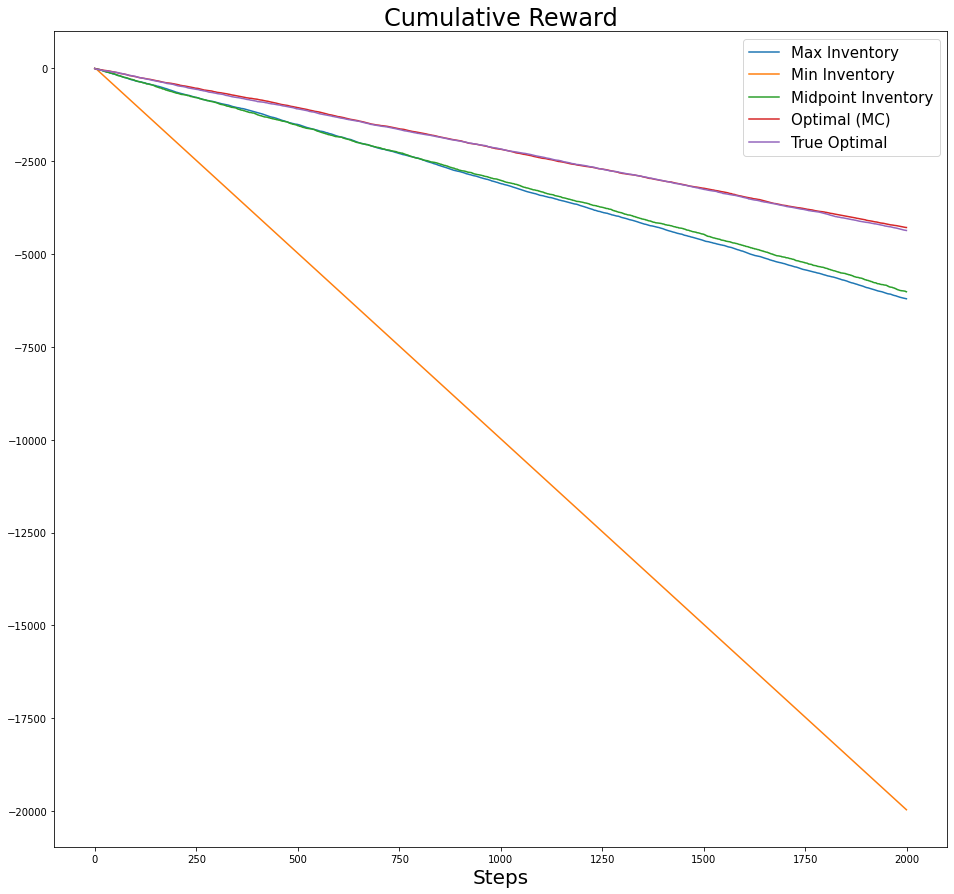

In [92]:
fig,axs = plt.subplots(figsize=(16,15))
axs.set_xlabel('Steps', fontsize=20)
axs.set_title(f'Cumulative Reward', fontsize=24)
for i,cum_r in enumerate(plot_list):
  axs.plot(cum_r, label=label_list[i])
# axs.set_ylim([-5000,0])
axs.legend(fontsize=15);

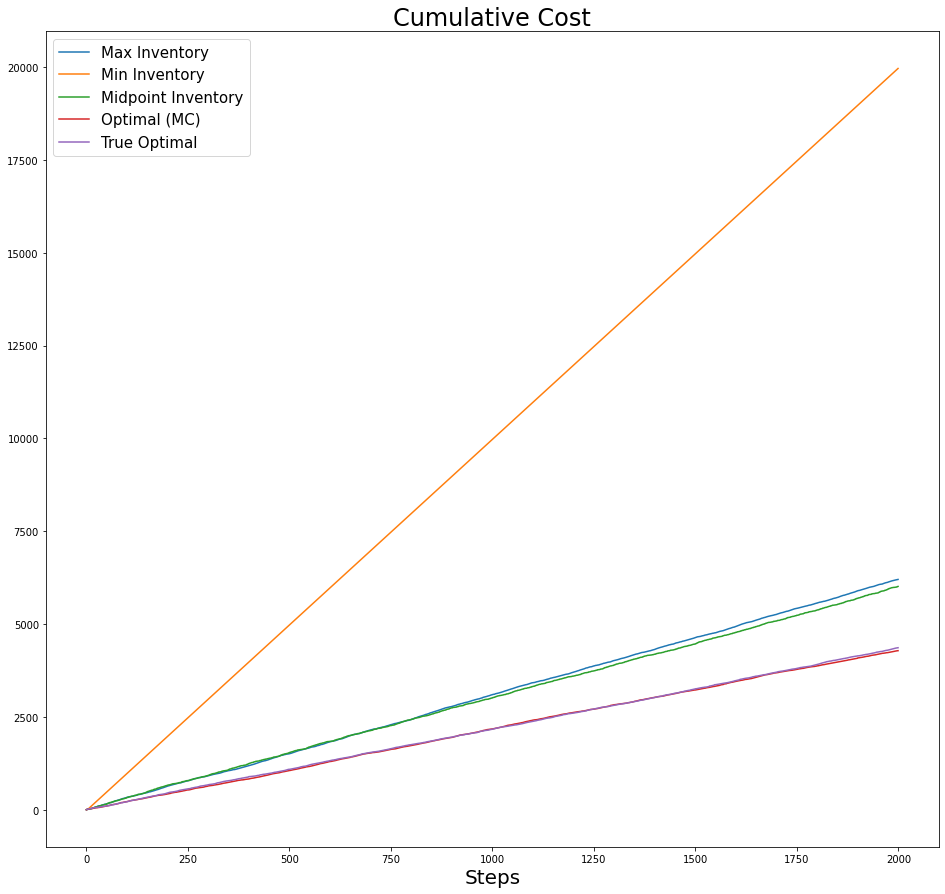

In [93]:
fig,axs = plt.subplots(figsize=(16,15))
axs.set_xlabel('Steps', fontsize=20)
axs.set_title(f'Cumulative Cost', fontsize=24)
for i,cum_r in enumerate(plot_list):
  axs.plot(-cum_r, label=label_list[i])
# axs.set_ylim([0, 5000])
axs.legend(fontsize=15);

Now we zoom in a bit:

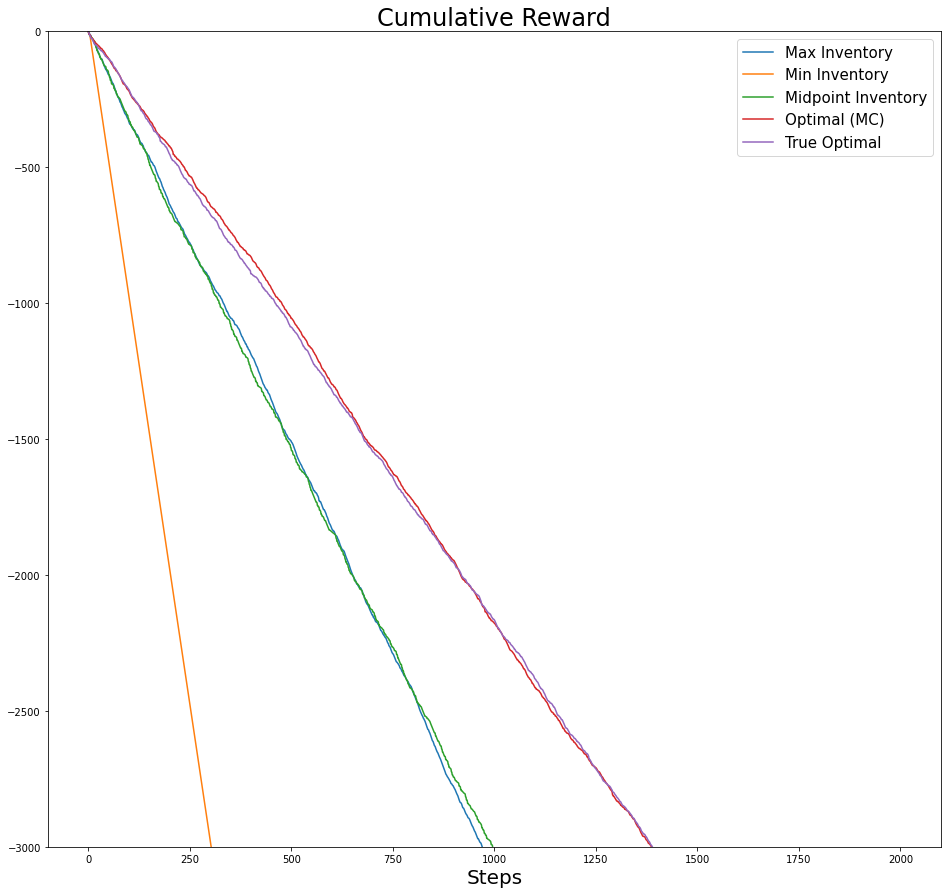

In [94]:
fig,axs = plt.subplots(figsize=(16,15))
axs.set_xlabel('Steps', fontsize=20)
axs.set_title(f'Cumulative Reward', fontsize=24)
for i,cum_r in enumerate(plot_list):
  axs.plot(cum_r, label=label_list[i])
axs.set_ylim([-3000,0])
axs.legend(fontsize=15);

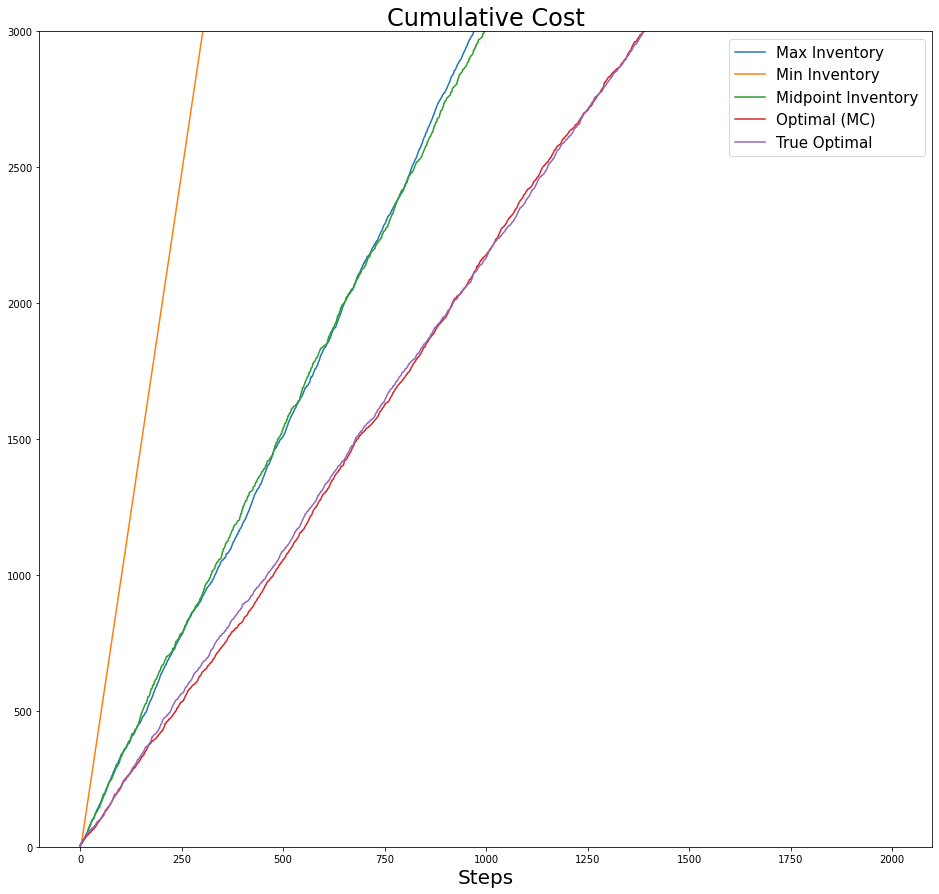

In [95]:
fig,axs = plt.subplots(figsize=(16,15))
axs.set_xlabel('Steps', fontsize=20)
axs.set_title(f'Cumulative Cost', fontsize=24)
for i,cum_r in enumerate(plot_list):
  axs.plot(-cum_r, label=label_list[i])
axs.set_ylim([0, 3000])
axs.legend(fontsize=15);